In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_image(img, shape=(15, 15), img_type="bgr"):
    plt.rcParams["figure.figsize"] = shape
    if img_type == "bgr":
        plt.imshow(img[:, :, [2, 1, 0]])
    elif img_type.lower() == "gray":
        plt.imshow(img, cmap='gray')


def show_keypoints(img, keypoints):
    img = cv2.drawKeypoints(image=img, keypoints=keypoints, outImage=np.array(
        []), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    show_image(img)


def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [3]:
#https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
def get_sift_features(img):
    if len(img.shape) == 3:
        img = to_grayscale(img)
    sift_obj = cv2.xfeatures2d.SIFT_create()
    return sift_obj.detectAndCompute(img, None)

In [4]:
def get_sift_features_and_show(img, show=False):
    keypoints = get_sift_features(img)
    if(show):
        show_keypoints(img, keypoints[0])
    return keypoints

In [25]:
def cv_matcher(img1, desc1, img2, desc2, kp1=None, kp2=None, threshold=0.75):
    brute_force_matcher = cv2.BFMatcher()

    # Match descriptors.
    matches = brute_force_matcher.knnMatch(desc1, desc2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        print(m,n)
        if m.distance < threshold * n.distance:
            good.append(m)

    if kp1 != None and kp2 != None:
        img3 = cv2.drawMatches(img1, kp1, img2, kp2,
                               good, outImg=np.array([]))  # , matchColor=(0, 255, 0))
        show_image(img3)

In [22]:
cv2.BFMatcher.knnMatch?

In [6]:
img1 = cv2.imread("../data/nevada4.jpg")
img2 = cv2.imread("../data/nevada5.jpg")

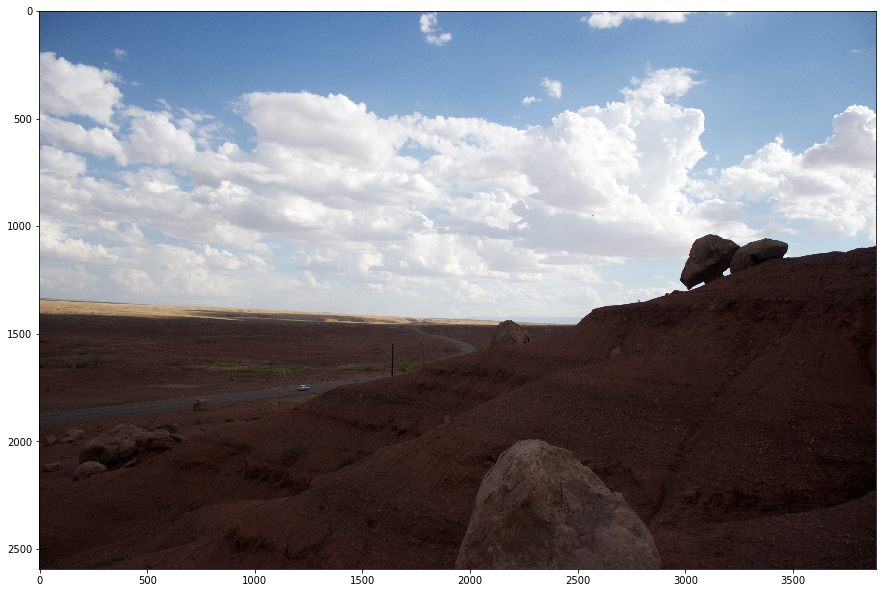

In [7]:
show_image(img1)

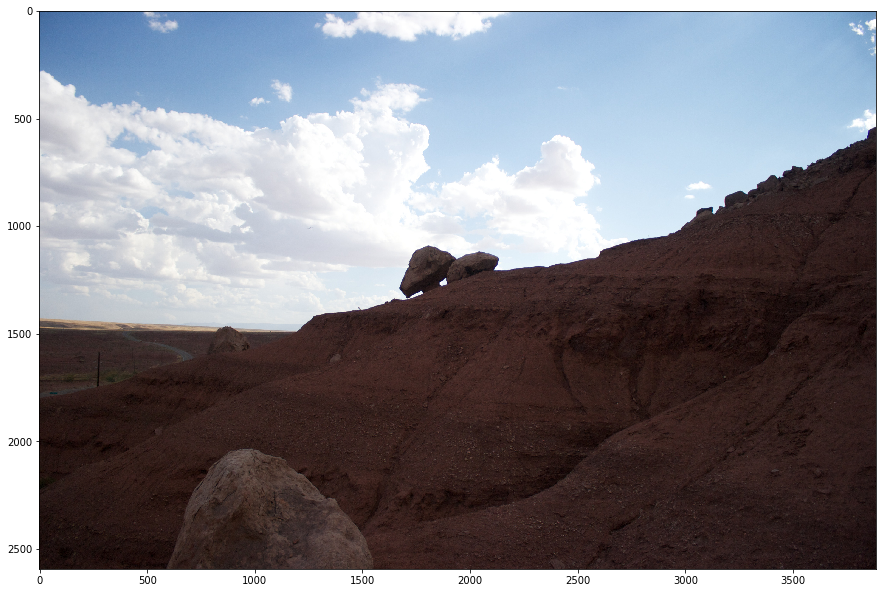

In [8]:
show_image(img2)

In [9]:
keypoints1, descriptors1 = get_sift_features_and_show(img1)
keypoints2, descriptors2 = get_sift_features_and_show(img2)

In [24]:
cv_matches = cv_matcher(img1, descriptors1, img2, descriptors2, keypoints1, keypoints2)

In [50]:
'''
 Nieghbours fixed to 2
'''
def knn_matcher(arr1, arr2, neighbours=2, img_id=2, threshold = 0.8):
    all_distances = np.sqrt(np.square(arr2).sum(
        axis=1)[:, np.newaxis] + np.square(arr1).sum(axis=1) - 2 * arr2.dot(arr1.T))

    closest_indices = np.argsort(all_distances, axis=1)[:, :neighbours]
    closest_distance = all_distances[:, closest_indices]

    index_num = np.repeat(np.arange(arr1.shape[0]), neighbours)
    closest_distance = closest_distance.flatten()
    closest_indices = closest_indices.flatten()

    to_return = []
    for train_id, query_id, distance in zip(index_num, closest_indices, closest_distance):
        to_return.append(cv2.DMatch(_trainIdx=train_id, _queryIdx=query_id,
                                    _distance=distance, _imgIdx=img_id))
    # Apply ratio test
    good = []
    assert neighbours==2
    matches = np.array(to_return).reshape(-1, neighbours)
    if threshold:
        for m, n in matches:
            if m.distance < threshold * n.distance:
                good.append(m)

        return good
    return matches

In [51]:
matches = knn_matcher(descriptors1, descriptors2 )

In [52]:
def draw_matches(img1, img2, kp1, kp2, matches):
    img3 = cv2.drawMatches(img1, kp1, img2, kp2,
                           matches, outImg=np.array([]))  # , matchColor=(0, 255, 0))
    show_image(img3)

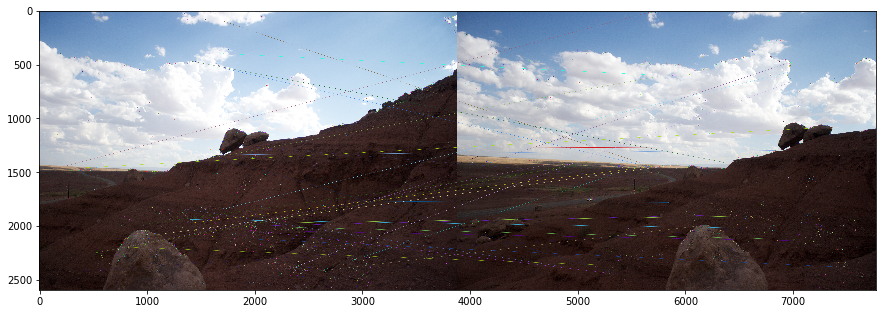

In [55]:
draw_matches(img1, img2, keypoints1, keypoints2, matches)